### WIP Time-Series w/ Prophet

Q: What do We want to predict?

A: We want to predict the number of reviews

In [1]:
#install
!pip install prophet

In [2]:
# imports
import prophet
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#from fbprophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
# read the data
# Initialize an empty DataFrame to store the data
reviews = pd.DataFrame()

# Define the file path
file_path = '/gdrive/My Drive/ADC/yelp_project/datasets/tucson_reviews.csv'

# Specify the chunk size
chunksize = 100000

# Read the file in chunks and concatenate them
for chunk in pd.read_csv(file_path, chunksize=chunksize):
    reviews = pd.concat([reviews, chunk])

# Now, 'reviews' contains the entire dataset

In [5]:
# show the data
reviews.head()


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,UBp0zWyH60Hmw6Fsasei7w,4Uh27DgGzsp6PqrH913giQ,otQS34_MymijPTdNBoBdCw,4,0,2,0,The bun makes the Sonoran Dog. It's like a snu...,2011-10-27 17:12:05
1,ymhbOMW63B_vGaRFR3XT0A,yZdAhQ_KmKuCZmbBy9YDQg,5Ce3lZksYVkCbrihqylVHQ,5,0,0,0,I just started going to Sushi Nara this month ...,2014-07-25 17:56:26
2,ypFqmURIY41F4pWaMW1VrQ,hToW2eoTAYlOcuNz7I73Cg,7L1kXfwU5XM6f6Jxo_L7Yg,5,1,0,0,We've been coming here since I was a kid. The ...,2015-07-03 22:36:04
3,M7h8K7PrLrN8yQb3RhHLdA,CysTz612pTix75Fye6-D4Q,WLiqfxv_GhFFA5sm878a2w,5,0,1,1,Blew $80 on food for the family was worth it f...,2013-12-29 03:15:34
4,_u331rYIp7qJ7aWvLup9Ug,BUpAhzsbbKbTqyBjT8YnNQ,wa_bwyY57etHjtJ2Fw0E3g,5,0,0,0,Called in a Mediterranean chicken shawarma. Go...,2014-04-01 05:00:09


In [6]:
# read business data
business = pd.read_csv('/gdrive/My Drive/ADC/yelp_project/datasets/tucson_business.csv')

In [7]:
# show business data
business.head(10)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.250960,-110.959158,4.0,446,1,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21..."
1,Y3ZCO17N1_T_Ms1JmswwzA,Taqueria Pico De Gallo,2618 S 6th Ave,Tucson,AZ,85713,32.192017,-110.968540,4.0,397,1,"{'RestaurantsGoodForGroups': 'True', 'Caters':...","Mexican, Restaurants","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ..."
2,lhsQkb5nhf-Kd5OvgB9MNg,Sachiko Sushi,3210 E Valencia Rd,Tucson,AZ,85706,32.133679,-110.923443,3.5,191,1,"{'RestaurantsPriceRange2': '2', 'BusinessAccep...","Japanese, Restaurants, Sushi Bars","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'..."
3,XyGRDrgCK0z4CiA6nhwEaw,Persian Room Fine Dining,"9290 N Thornydale Rd, Ste 100",Tucson,AZ,85742,32.375016,-111.046320,4.5,258,1,"{'Alcohol': ""'full_bar'"", 'GoodForMeal': ""{'de...","Restaurants, Persian/Iranian, Mediterranean","{'Monday': '11:0-21:30', 'Tuesday': '11:0-21:3..."
4,-3-6BB10tIWNKGEF0Es2BA,The 81 Hong Kong Cafe,"625 E Wetmore Rd, Ste 109",Tucson,AZ,85705,32.288540,-110.963144,4.0,133,1,"{'Alcohol': ""u'none'"", 'DogsAllowed': 'False',...","Coffee & Tea, Asian Fusion, Food, Bubble Tea, ...","{'Monday': '0:0-0:0', 'Wednesday': '10:0-21:0'..."
5,UCMSWPqzXjd7QHq7v8PJjQ,Prep & Pastry,2660 N Campbell Ave,Tucson,AZ,85719,32.255528,-110.943492,4.5,2126,1,"{'Alcohol': ""u'full_bar'"", 'BikeParking': 'Tru...","Restaurants, Cocktail Bars, Bars, Comfort Food...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-15:0', '..."
6,aq26RY75PlTNsviW6wUC9A,Hooters,7280 E Broadway Blvd,Tucson,AZ,85710,32.220600,-110.837971,3.5,109,1,"{'Alcohol': ""'full_bar'"", 'RestaurantsAttire':...","Sports Bars, Food, American (Traditional), Nig...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
7,8QJTzIaR5FceGds8HBSIig,Barrio Brewing,800 E 16th St,Tucson,AZ,85719,32.214412,-110.959512,4.0,611,1,"{'RestaurantsReservations': 'False', 'GoodForK...","Nightlife, Sports Bars, Bars, Breweries, Pubs,...","{'Monday': '11:0-19:0', 'Tuesday': '11:0-22:0'..."
8,5Ce3lZksYVkCbrihqylVHQ,Sushi Nara,64 N Harrison Rd,Tucson,AZ,85748,32.222552,-110.788132,4.5,159,1,"{'RestaurantsPriceRange2': '2', 'HasTV': 'True...","Sushi Bars, Japanese, Restaurants","{'Monday': '16:30-20:0', 'Tuesday': '16:30-20:..."
9,-y5vYOsyL4bSFxeOtQtYbg,AJ's Fine Foods,2805 E Skyline Dr,Tucson,AZ,85718,32.324425,-110.931614,4.0,258,1,"{'GoodForKids': 'True', 'Caters': 'True', 'Out...","Delis, Bakeries, Food, Grocery, Restaurants","{'Monday': '6:0-21:0', 'Tuesday': '6:0-21:0', ..."


In [8]:
# join the files using business id
tucson_sample = pd.merge(business, reviews, on='business_id')

In [9]:
# show the new data
tucson_sample.head(10)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,review_count,...,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date
0,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",xnA_bGa4zJ7fLUPTOCT0-A,nabJKapjKahYfTtnBDG6JQ,4,1,0,0,One of my most favorite Indian restaurants. No...,2011-04-22 02:02:10
1,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",453I3aMT_YCQW655gKkzdQ,SmaAK6il7pyldoqZrH7iTA,4,0,0,1,Food= Amazing\nService= Great\nPrices= Reasona...,2014-04-20 00:32:54
2,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",QTE44bHheG6ugQU4em4SdQ,B6FbaEEn5Uh4kEqv4kUdgA,3,0,0,0,"OK lunch buffet, but too oily. i think weeken...",2005-03-12 03:47:06
3,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",5f42pKbzLJWwtsa0StDwgA,OqTs0lHg5ZXvF1S0bJfzFA,5,0,0,0,"Favorite indian place in Tucson, hands down! M...",2013-01-28 02:55:30
4,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",-vIuycScTA7SVwHDi1ENeg,QaBNIUwzgN4v_5wjmlJOCg,4,3,1,1,"I'm torn between 3 and 4 stars, but have decid...",2011-02-14 18:01:48
5,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",PdSiuKq-zR6msuU1Rs3n-g,yUngqxBzqCgcdL4heo4Heg,5,0,0,0,"Everybody in our lab is a fan of their food, a...",2018-09-14 22:24:42
6,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",qRWMrRowaqlwcezBpwgsTw,iR2pcr2ssSBAM446HeT2hA,2,1,1,0,"Service = pleasant, but not outstanding by any...",2010-11-22 15:14:21
7,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",K1opRk4GKwUUtBp6K2cocg,7AcGs_uVHFcnoHsKETBy7g,4,1,0,0,I've become a fan of Sher-e Punjab over the la...,2009-08-08 22:18:48
8,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",CqDc5QznNTCgyZQSxeq25A,-f4o4UgaTqfolTsWZswjYw,5,1,0,0,Best Indian food I have had in Tucson! Veggie ...,2016-07-04 07:16:29
9,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,85719,32.25096,-110.959158,4.0,446,...,"Restaurants, Salad, Pakistani, Indian, Cocktai...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21...",vdrOv8KhWSaN8H68cxjWBQ,axhEZ874NTw_e2A5R9HSjg,5,0,0,0,BEST Indian food I have ever had. Their tikka ...,2016-12-20 00:49:59


In [10]:
# show the columns
tucson_sample.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars_x', 'review_count', 'is_open',
       'attributes', 'categories', 'hours', 'review_id', 'user_id', 'stars_y',
       'useful', 'funny', 'cool', 'text', 'date'],
      dtype='object')

In [11]:
# drop unnecessary columns
columns_to_drop = ['postal_code', 'latitude', 'longitude', 'is_open', 'hours', 'useful', 'funny', 'cool']

# Use the drop method to remove the specified columns
tucson_sample = tucson_sample.drop(columns=columns_to_drop)

In [12]:
# show columns again
tucson_sample.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'stars_x',
       'review_count', 'attributes', 'categories', 'review_id', 'user_id',
       'stars_y', 'text', 'date'],
      dtype='object')

In [13]:
# set the date to index
tucson_sample = tucson_sample.set_index('date')
tucson_sample.index = pd.to_datetime(tucson_sample.index)

In [14]:
# show the data
tucson_sample.head()

,business_id,name,address,city,state,stars_x,review_count,attributes,categories,review_id,user_id,stars_y,text
date,,,,,,,,,,,,,
2011-04-22 02:02:10,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,4.0,446,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Restaurants, Salad, Pakistani, Indian, Cocktai...",xnA_bGa4zJ7fLUPTOCT0-A,nabJKapjKahYfTtnBDG6JQ,4,One of my most favorite Indian restaurants. No...
2014-04-20 00:32:54,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,4.0,446,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Restaurants, Salad, Pakistani, Indian, Cocktai...",453I3aMT_YCQW655gKkzdQ,SmaAK6il7pyldoqZrH7iTA,4,Food= Amazing\nService= Great\nPrices= Reasona...
2005-03-12 03:47:06,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,4.0,446,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Restaurants, Salad, Pakistani, Indian, Cocktai...",QTE44bHheG6ugQU4em4SdQ,B6FbaEEn5Uh4kEqv4kUdgA,3,"OK lunch buffet, but too oily. i think weeken..."
2013-01-28 02:55:30,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,4.0,446,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Restaurants, Salad, Pakistani, Indian, Cocktai...",5f42pKbzLJWwtsa0StDwgA,OqTs0lHg5ZXvF1S0bJfzFA,5,"Favorite indian place in Tucson, hands down! M..."
2011-02-14 18:01:48,f82dhKNiUXsDVPMLqKYiIQ,Sher-e-Punjab,853 East Grant Rd,Tucson,AZ,4.0,446,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Restaurants, Salad, Pakistani, Indian, Cocktai...",-vIuycScTA7SVwHDi1ENeg,QaBNIUwzgN4v_5wjmlJOCg,4,"I'm torn between 3 and 4 stars, but have decid..."


### Time-Series with Prophet

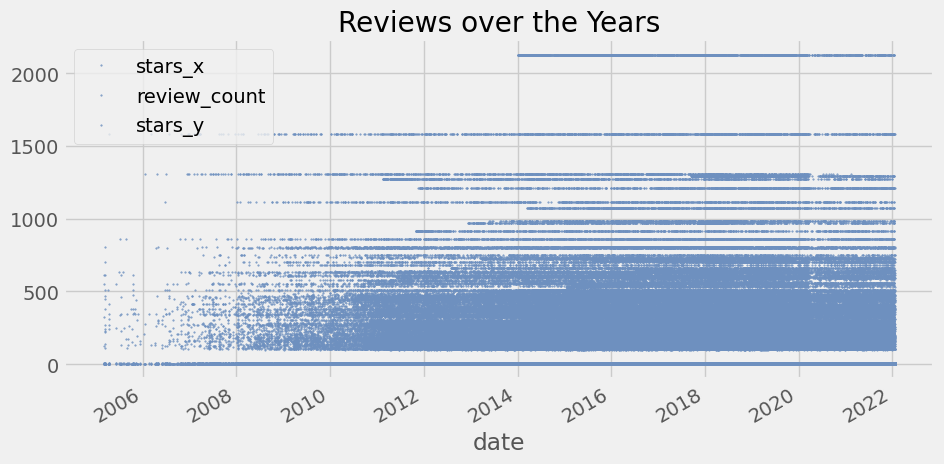

In [15]:
# plot the data
color_pal = sns.color_palette('vlag')
tucson_sample.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='Reviews over the Years')
plt.show()

In [16]:
# creating features to separate the data into days, month, year, season, etc.
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(tucson_sample, label='review_count')
features_and_target = pd.concat([X, y], axis=1)

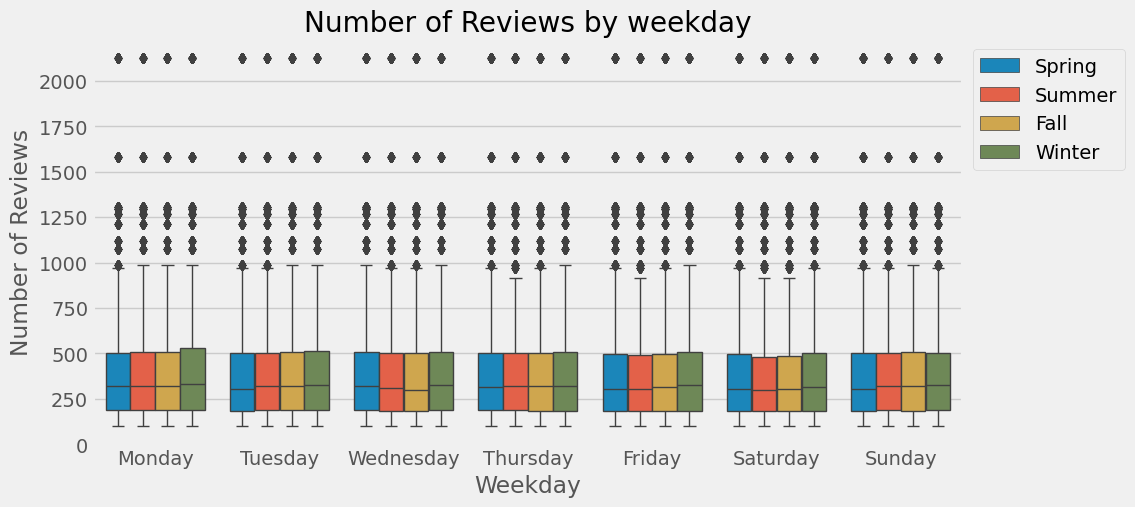

In [17]:
# plot data by season
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='review_count',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Number of Reviews by weekday')
ax.set_xlabel('Weekday')
ax.set_ylabel('Number of Reviews')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

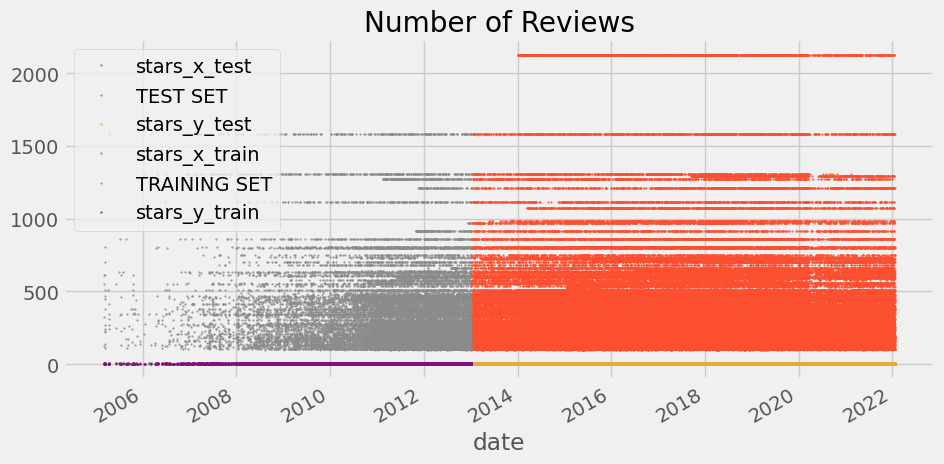

In [18]:
# starting with ml pipeline
#train-> grey | test-> red
split_date = '1-Jan-2013'
tucson_train = tucson_sample.loc[tucson_sample.index <= split_date].copy()
tucson_test = tucson_sample.loc[tucson_sample.index > split_date].copy()

# add suffixes to the columns
tucson_train = tucson_train.add_suffix('_train')
tucson_test = tucson_test.add_suffix('_test')

# plot train and test
tucson_test \
    .rename(columns={'review_count_test': 'TEST SET'}) \
    .join(tucson_train.rename(columns={'review_count_train': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='Number of Reviews', style='.', ms=1)
plt.show()

In [19]:
# format data for prophet model using ds and y: ds should be our datetime data, and y should be our target data
tucson_train_prophet = tucson_train.reset_index() \
    .rename(columns={'date':'ds',
                     'review_count_train':'y'})
tucson_train_prophet.columns

Index(['ds', 'business_id_train', 'name_train', 'address_train', 'city_train',
       'state_train', 'stars_x_train', 'y', 'attributes_train',
       'categories_train', 'review_id_train', 'user_id_train', 'stars_y_train',
       'text_train'],
      dtype='object')

In [20]:
# creating the prophet model using default features
from prophet import Prophet

model = Prophet()
model.fit(tucson_train_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfa35yujw/_id8v75g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfa35yujw/bf6k6b0o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86183', 'data', 'file=/tmp/tmpfa35yujw/_id8v75g.json', 'init=/tmp/tmpfa35yujw/bf6k6b0o.json', 'output', 'file=/tmp/tmpfa35yujw/prophet_model01b15_bd/prophet_model-20231005132157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [21]:
# after training the model, we can run the 'predict' command
# predict on test set
tucson_test_prophet = tucson_test.reset_index() \
    .rename(columns={'date':'ds',
                     'review_count_test':'y'})

tucson_test_frcst = model.predict(tucson_test_prophet)

In [22]:
# show the new dataframe
tucson_test_frcst.head() #yhat (last column) represents the predictive value(s)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01 00:37:50,375.613300,-0.112994,752.800814,375.613300,375.613300,18.292935,18.292935,18.292935,-1.529783,...,7.037453,7.037453,7.037453,12.785265,12.785265,12.785265,0.0,0.0,0.0,393.906235
1,2013-01-01 00:37:51,375.613299,-3.392241,743.395088,375.613299,375.613299,18.293065,18.293065,18.293065,-1.529535,...,7.037330,7.037330,7.037330,12.785269,12.785269,12.785269,0.0,0.0,0.0,393.906364
2,2013-01-01 00:46:44,375.613143,40.416506,750.237550,375.613143,375.613143,18.386336,18.386336,18.386336,-1.372907,...,6.971935,6.971935,6.971935,12.787308,12.787308,12.787308,0.0,0.0,0.0,393.999480
3,2013-01-01 00:53:22,375.613027,27.598204,757.644273,375.613027,375.613027,18.489696,18.489696,18.489696,-1.221892,...,6.922762,6.922762,6.922762,12.788826,12.788826,12.788826,0.0,0.0,0.0,394.102723
4,2013-01-01 01:10:58,375.612718,13.727179,760.854569,375.612718,375.612718,18.922152,18.922152,18.922152,-0.661581,...,6.790896,6.790896,6.790896,12.792837,12.792837,12.792837,0.0,0.0,0.0,394.534870


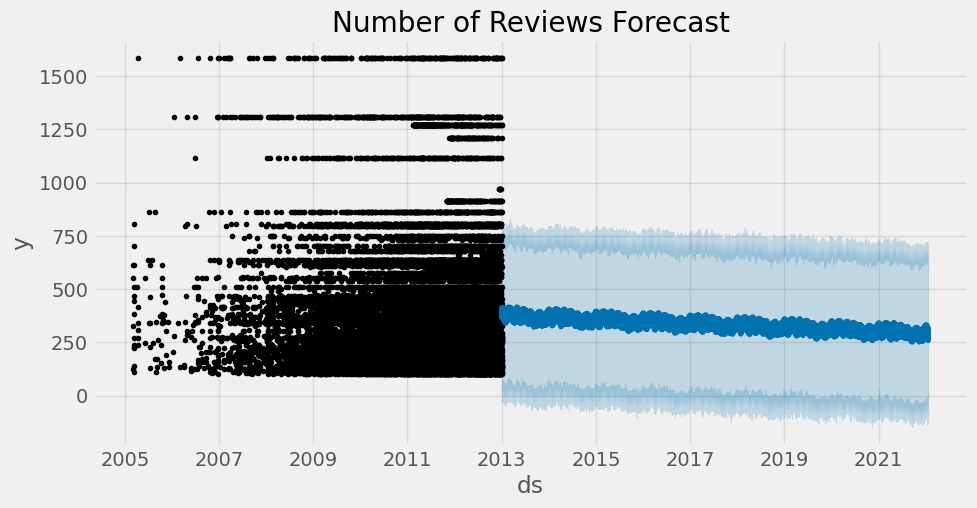

In [23]:
# plot the forecasted values
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(tucson_test_frcst, ax=ax)
ax.set_title('Number of Reviews Forecast')
plt.show() # y represents the target (number of reviews) and ds represents the date, which in this case is in years
# along with the predictions (in dark blue), we also have confidence intervals (in lighter blue)

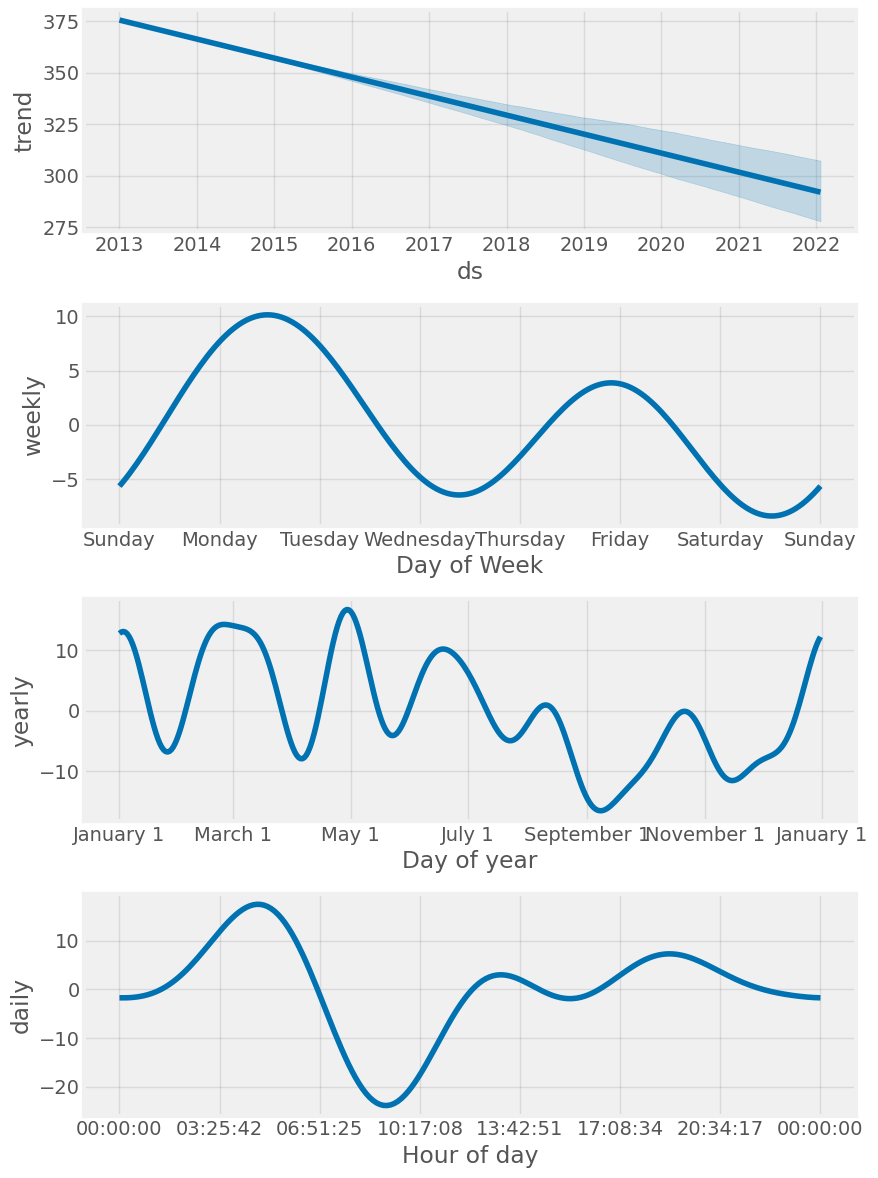

In [24]:
# lets plot the different prophet components of the data frame
fig = model.plot_components(tucson_test_frcst)
plt.show() # trend | weekly | yearly | daily
# the model combined these components to create the forecast above

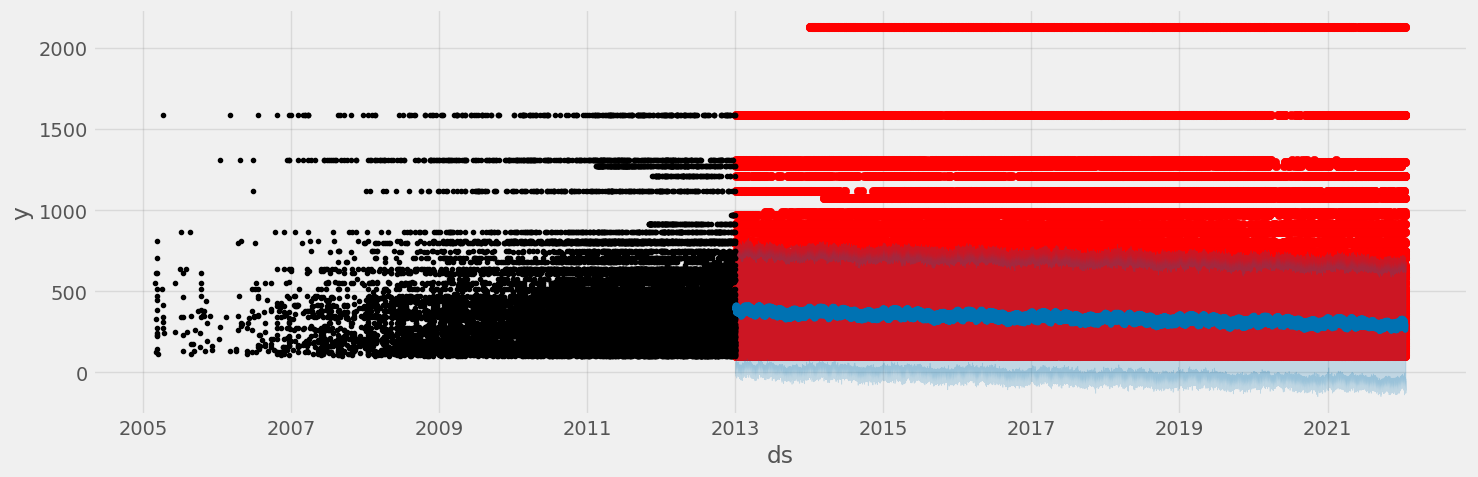

In [25]:
# evaluate the model
# let's compare the forecast with the actual number of reviews for each year
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(tucson_test.index, tucson_test['review_count_test'], color='r')
fig = model.plot(tucson_test_frcst, ax=ax)
# red-> actual values | blue-> predicted values | it looks like prophet picked up a downward trend

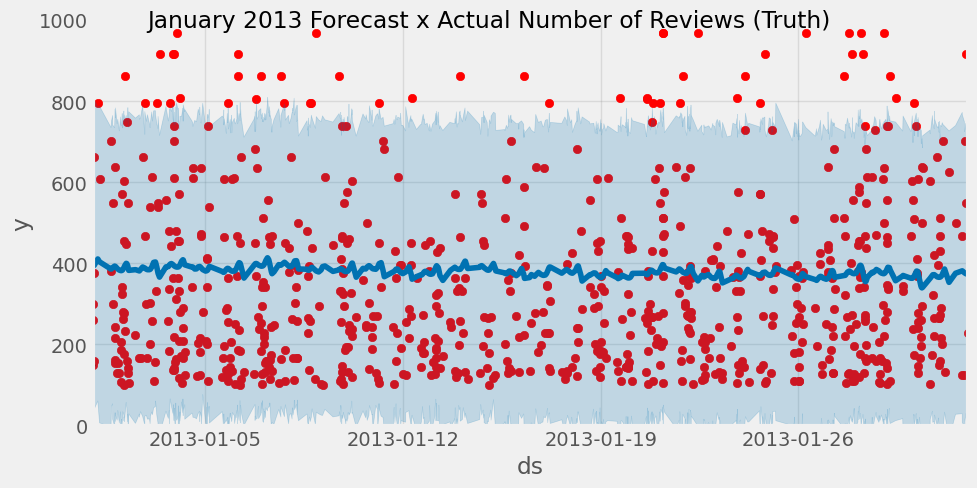

In [26]:
# now let's look at a more narrow time window-> starting with the first month year of our prediction, which is january 2013
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(tucson_test.index, tucson_test['review_count_test'], color='r')
fig = model.plot(tucson_test_frcst, ax=ax)

from datetime import datetime

lower_date = datetime.strptime('2013-01-01', '%Y-%m-%d')
upper_date = datetime.strptime('2013-02-01', '%Y-%m-%d')

ax.set_xbound(lower=lower_date, upper=upper_date)
ax.set_ylim(0, 1000)
plot = plt.suptitle('January 2013 Forecast x Actual Number of Reviews (Truth)')

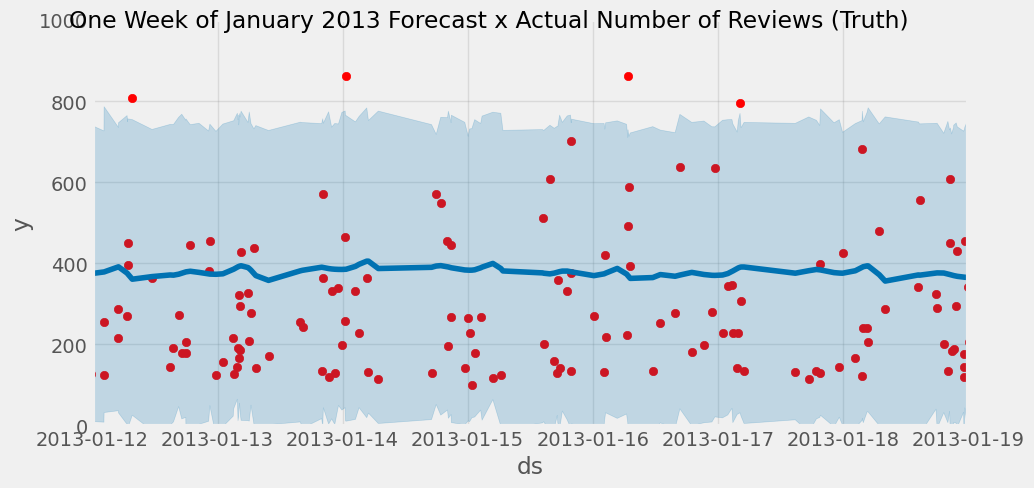

In [27]:
# now let's look at the one week! January 12th-19th 2013, since we can see above that the first two weeks don´t have reviews
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(tucson_test.index, tucson_test['review_count_test'], color='r')
fig = model.plot(tucson_test_frcst, ax=ax)

from datetime import datetime

lower_date = datetime.strptime('2013-01-12', '%Y-%m-%d')
upper_date = datetime.strptime('2013-01-19', '%Y-%m-%d')

ax.set_xbound(lower=lower_date, upper=upper_date)
ax.set_ylim(0, 1000)
plot = plt.suptitle('One Week of January 2013 Forecast x Actual Number of Reviews (Truth)')

In [28]:
# evaluate with error metrics
# root mean squared error | mean absolute error | mean absolute percent error
# RMSE
np.sqrt(mean_squared_error(y_true=tucson_test['review_count_test'],
                   y_pred=tucson_test_frcst['yhat'])) # better performance than xgboost

352.3239174285363

In [29]:
# MAE
mean_absolute_error(y_true=tucson_test['review_count_test'],
                   y_pred=tucson_test_frcst['yhat'])

223.20572280316583

In [30]:
# MAPE
# percent value that is 'off' on average
mean_absolute_percentage_error(y_true=tucson_test['review_count_test'],
                   y_pred=tucson_test_frcst['yhat'])

64.36374562521023

In [31]:
# holidays-> since we are working with a city from the USA, we will take USA Holidays into consideration
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()


holidays = cal.holidays(start=tucson_sample.index.min(),
                        end=tucson_sample.index.max(),
                        return_name=True)
holiday_tucson = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_tucson = holiday_tucson.reset_index().rename(columns={'index':'ds'})

In [32]:
# show unique holidays/holiday
holiday_tucson.value_counts()

ds          holiday                            
2005-05-30  Memorial Day                           1
2016-12-26  Christmas Day                          1
2016-01-18  Birthday of Martin Luther King, Jr.    1
2016-02-15  Washington’s Birthday                  1
2016-05-30  Memorial Day                           1
                                                  ..
2011-01-17  Birthday of Martin Luther King, Jr.    1
2011-02-21  Washington’s Birthday                  1
2011-05-30  Memorial Day                           1
2011-07-04  Independence Day                       1
2022-01-17  Birthday of Martin Luther King, Jr.    1
Length: 170, dtype: int64

In [33]:
# create a new prophet model for the holidays dataset
model_with_holidays = Prophet(holidays=holiday_tucson)
model_with_holidays.fit(tucson_train_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfa35yujw/r4ih1ebe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfa35yujw/rikv4c7h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26023', 'data', 'file=/tmp/tmpfa35yujw/r4ih1ebe.json', 'init=/tmp/tmpfa35yujw/rikv4c7h.json', 'output', 'file=/tmp/tmpfa35yujw/prophet_models21_1y56/prophet_model-20231005132318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:23:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:23:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [34]:
# predict on training set
tucson_test_frcst_with_hols = \
    model_with_holidays.predict(df=tucson_test_prophet)

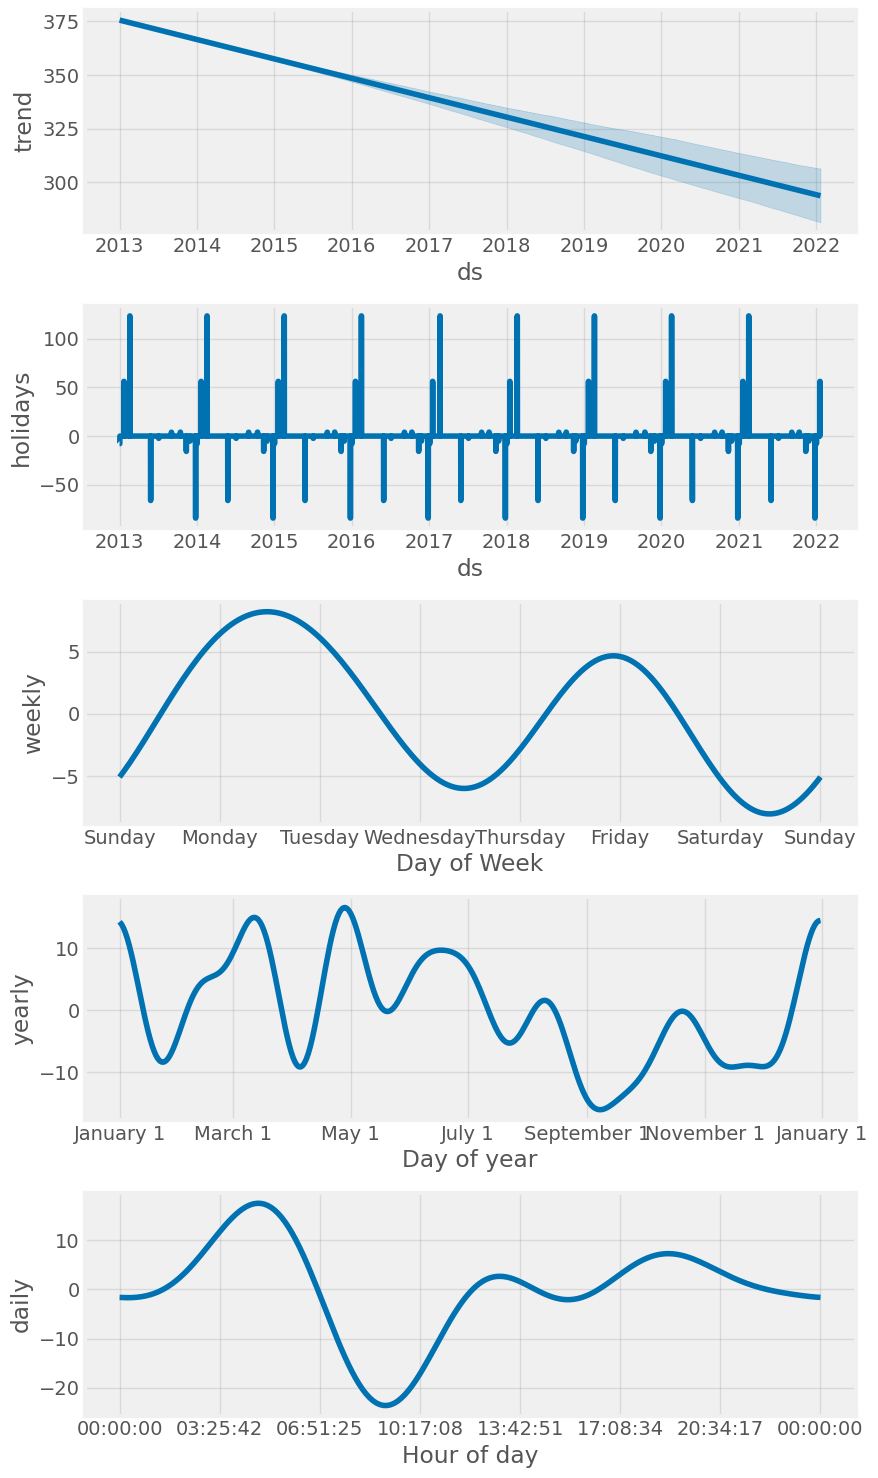

In [35]:
# let's plot the different components again, this time using the holidays data
fig = model_with_holidays.plot_components(
    tucson_test_frcst_with_hols)
plt.show()

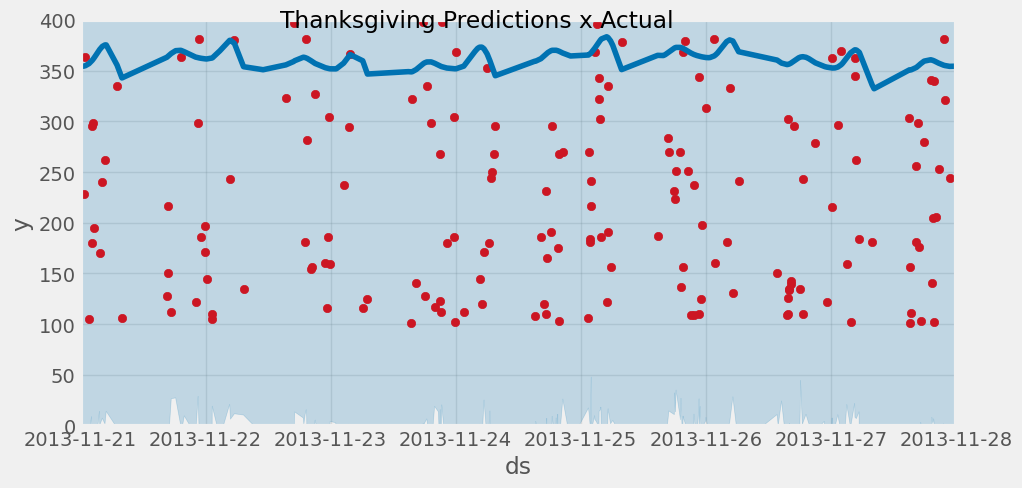

In [36]:
# plot the data for Thanksgiving week in 2013
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(tucson_test.index, tucson_test['review_count_test'], color='r')
fig = model.plot(tucson_test_frcst_with_hols, ax=ax)

# christmas/new years week
from datetime import datetime

lower_date = datetime.strptime('2013-11-21', '%Y-%m-%d')
upper_date = datetime.strptime('2013-11-28', '%Y-%m-%d')


ax.set_xbound(lower=lower_date,
              upper=upper_date)
ax.set_ylim(0, 400)
plot = plt.suptitle('Thanksgiving Predictions x Actual')

In [37]:
# evaluation metrics again, this time including holidays
# RMSE
np.sqrt(mean_squared_error(y_true=tucson_test['review_count_test'],
                   y_pred=tucson_test_frcst_with_hols['yhat']))

352.27602667760164

In [38]:
# MAE
mean_absolute_error(y_true=tucson_test['review_count_test'],
                   y_pred=tucson_test_frcst_with_hols['yhat'])

223.41791266459384

In [39]:
# MAPE
mean_absolute_percentage_error(y_true=tucson_test['review_count_test'],
                   y_pred=tucson_test_frcst_with_hols['yhat'])

64.68465565552253

In [43]:
# future predictions! using the prophet's make future dataframe component-> 10 years, yearly frequency
future = model.make_future_dataframe(periods=20, freq='y', include_history=False)
forecast = model_with_holidays.predict(future)

In [44]:
# show the new dataframe
forecast[['ds','yhat']].head(11)

,ds,yhat
0,2013-12-31 23:31:07,375.592604
1,2014-12-31 23:31:07,367.452953
2,2015-12-31 23:31:07,366.145260
3,2016-12-31 23:31:07,347.004119
4,2017-12-31 23:31:07,349.606393
5,2018-12-31 23:31:07,340.628434
6,2019-12-31 23:31:07,321.499391
7,2020-12-31 23:31:07,320.800965
8,2021-12-31 23:31:07,294.353441
9,2022-12-31 23:31:07,292.935942


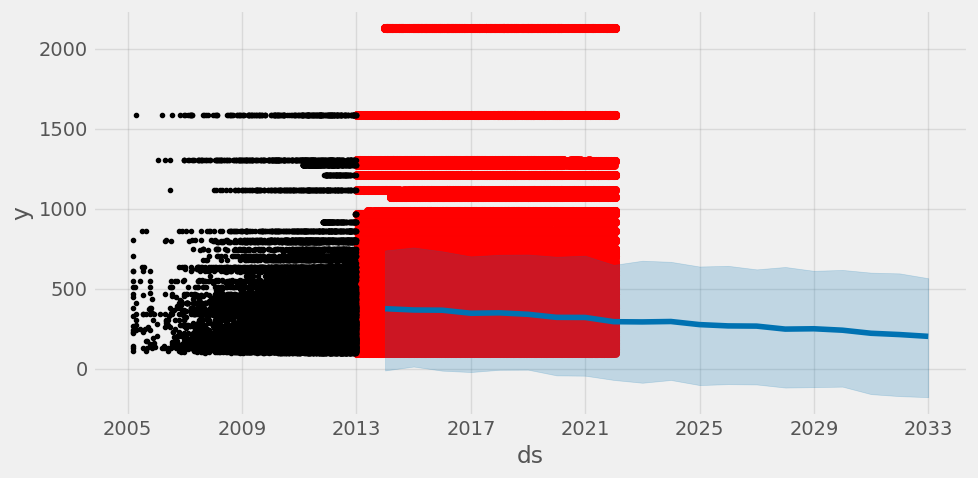

In [45]:
# plot the future predictions!
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(tucson_test.index, tucson_test['review_count_test'], color='r')
fig = model.plot(forecast, ax=ax)